# Importing Libraries

In [4]:
import gc
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential

from keras import backend as K
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [5]:
# Importing Data
data = pd.read_csv('../input/breakhis/Folds.csv')

# Image Directory
img_dir = '../input/breakhis/BreaKHis_v1/'

# Class Labels
class_names = ['benign', 'malignant']

# Data Pre-processing

In [6]:
# Renaming Column
if 'path' not in data.columns:
    data = data.rename(columns={'filename':'path'})

# Adding Columns with useful data
if 'label' or 'label_int' or 'filename' not in data.columns:
    data['label'] = data.path.apply(lambda x: x.split('/')[3])
    data['label_int'] = data.label.apply(lambda x: class_names.index(x))
    data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

# Printing Useful information
print("Data Shape: ", data.shape)
print("Folds: ", data.fold.unique())
print("Magnifications: ", data.mag.unique())
print("Labels: ", data.label.unique(), data.label_int.unique())

print("Dataset:")
data.head(3)

Data Shape:  (39545, 7)
Folds:  [1 2 3 4 5]
Magnifications:  [100 200  40 400]
Labels:  ['benign' 'malignant'] [0 1]
Dataset:


,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-003.png


### Visualizing Label Counts

Count of Benign    :  2480.0
Count of Malignant :  5429.0


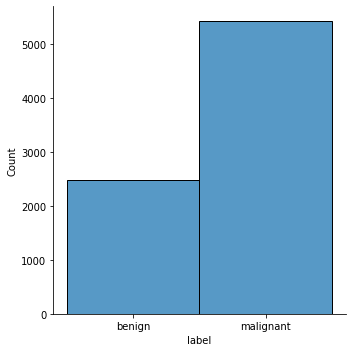

In [7]:
ax = sns.displot(data=data.iloc[0:7909], x='label')
print('Count of Benign    : ', data[data.label == 'benign'].label.count()/5)
print('Count of Malignant : ', data[data.label == 'malignant'].label.count()/5)

### Categorizing Data using Magnifications

Magnification: 100
malignant    1437.0
benign        644.0
Name: label, dtype: float64 

Magnification: 200
malignant    1390.0
benign        623.0
Name: label, dtype: float64 

Magnification: 40
malignant    1370.0
benign        625.0
Name: label, dtype: float64 

Magnification: 400
malignant    1232.0
benign        588.0
Name: label, dtype: float64 



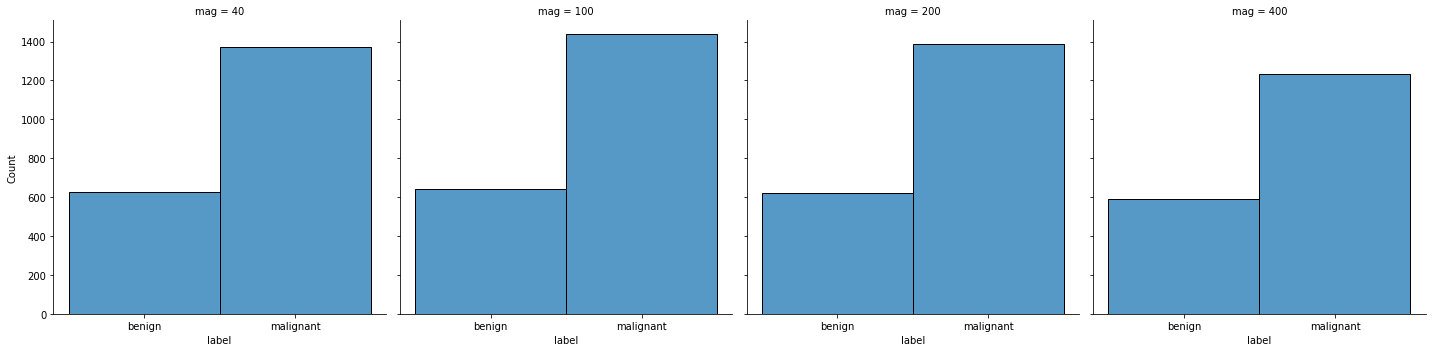

In [8]:
# Plotting Data for all magnifications
ax = sns.displot(data=data.iloc[0:7909], x='label', col='mag')

# Data Dict
data_dict = {}

# Categorizing for all mags
for mag in data['mag'].unique():
    data_dict[mag]=data.loc[data['mag'] == mag].copy()
    print('Magnification:', mag)
    print(data_dict[mag].label.value_counts()/5, "\n")

### Load and View Images

In [9]:
img_width = 224
img_height = 224
dim = (img_width, img_height)

# Iterating on Mags
for mag in data['mag'].unique():
    # Initializing images column
    data_dict[mag]['img_read'] = np.nan
    data_dict[mag]['img_read'] = data_dict[mag]['img_read'].astype(object)

    # Printing Info
    print("[INFO] Importing Images for Magnification",mag)

    # Iterating on all rows and reading image data
    for index, row in tqdm(data_dict[mag].iterrows(), total=data_dict[mag].shape[0]):
        img = cv2.imread(img_dir + row.path)
        if img.shape != (img_width, img_height, 3):
            img = cv2.resize(img, dim)
        data_dict[mag].at[index, 'img_read'] = img

[INFO] Importing Images for Magnification 100


100%|██████████| 10405/10405 [02:28<00:00, 69.86it/s]


[INFO] Importing Images for Magnification 200


100%|██████████| 10065/10065 [02:20<00:00, 71.50it/s]


[INFO] Importing Images for Magnification 40


100%|██████████| 9975/9975 [02:20<00:00, 70.88it/s] 


[INFO] Importing Images for Magnification 400


100%|██████████| 9100/9100 [02:06<00:00, 72.12it/s] 


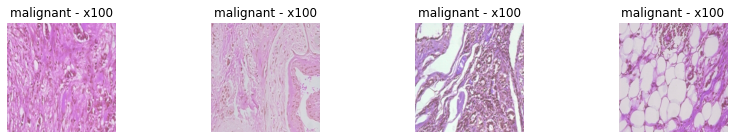

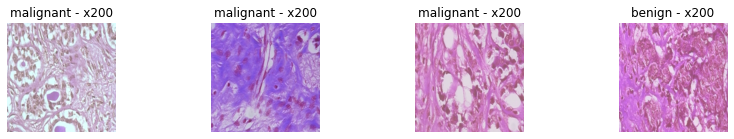

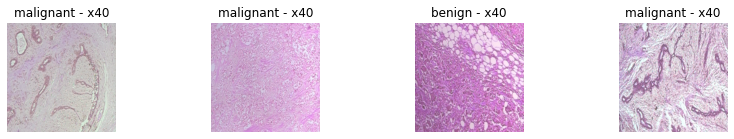

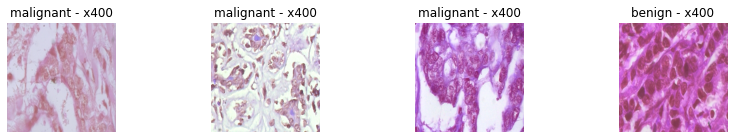

In [10]:
row = 1
col = 4
per_mag = 4

for mag in data['mag'].unique():
    fig, axes = plt.subplots(row, col, figsize=(3.5*col,2*row))
    for images, labels, i in zip(data_dict[mag].sample(per_mag).iloc[:, 7],
                                 data_dict[mag].sample(per_mag).iloc[:, 4],
                                 range(per_mag)):
        ax = axes[i]
        ax.imshow(images)
        ax.set_title(labels+" - x"+str(mag))
        ax.axis("off") 
    plt.show()

In [11]:
EPOCHS = 10
INIT_LR = 1e-4
BATCH_SIZE = 16
INPUT_SHAPE = (224,224,3)

In [12]:
def build_model(backbone, lr=INIT_LR):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])
    
    return model

In [13]:
# Early stop to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [14]:
datagen = ImageDataGenerator(rescale=1 / 255.0,
                              rotation_range=20,
                              zoom_range=0.05,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.05,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode="nearest")

In [15]:
def Train(mag, fold):
    # Train Data
    X_train = np.stack(data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="train")].img_read.to_list())
    y_train = data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="train")].label_int.to_list()
    y_train = to_categorical(y_train, num_classes= 2)

    # Test Data
    X_test = np.stack(data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="test")].img_read.to_list())
    y_test = data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="test")].label_int.to_list()

    # Validation Data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)
    
    # Initializing Model
    K.clear_session()
    gc.collect()
    DenseNet201_model = DenseNet201(weights='imagenet',
                                    include_top=False,
                                    input_shape=INPUT_SHAPE)
    model = build_model(DenseNet201_model , lr = INIT_LR)
    
    print("--------------------------------------------------------------------------------------------")
    print("                               [INFO] Training Model")
    print("--------------------------------------------------------------------------------------------")
    
    # Fit Model
    history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                         steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                         epochs= EPOCHS,
                         validation_data=(X_val/255, y_val),
                         callbacks=[early_stop],
                         verbose=1)
    
    print("--------------------------------------------------------------------------------------------")
    print("                               [INFO] Evaluating Model")
    print("--------------------------------------------------------------------------------------------")
    # Evaluate model
    model.evaluate(X_val, y_val)

    y_pred = model.predict(X_test/255)
    y_pred = np.argmax(y_pred,axis=1)
    
    return model, history, y_test, y_pred

In [16]:
def History_metrics(history):    
    sns.set()

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    #accuracy plot
    plt.plot(epochs, accuracy, color='b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.figure()
    #loss plot
    plt.plot(epochs, loss, color='g', label='Training Loss')
    plt.plot(epochs, val_loss, color='y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [17]:
def Model_report(y_test, y_pred):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='g')
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [18]:
mag_acc=np.empty((4,1))

# Magnification: 100x

In [19]:
mag =100

## Fold 1

In [20]:
m, history, y_test, y_pred = Train(mag, 1)

2022-01-06 23:42:12.607919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


74850304/74836368 [==============================] - 0s 0us/step
--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------


2022-01-06 23:42:12.713098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 23:42:12.713981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 23:42:12.715257: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-06 23:42:12.716456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Epoch 1/10


2022-01-06 23:42:40.809132: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


66/66 [==============================] - ETA: 0s - loss: 0.7226 - accuracy: 0.6042

2022-01-06 23:43:03.223943: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 159559680 exceeds 10% of free system memory.
2022-01-06 23:43:03.425251: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 159559680 exceeds 10% of free system memory.


66/66 [==============================] - 46s 318ms/step - loss: 0.7226 - accuracy: 0.6042 - val_loss: 0.5907 - val_accuracy: 0.7132
Epoch 2/10
66/66 [==============================] - 17s 258ms/step - loss: 0.5306 - accuracy: 0.7869 - val_loss: 0.6302 - val_accuracy: 0.6943
Epoch 3/10
66/66 [==============================] - 17s 253ms/step - loss: 0.3631 - accuracy: 0.9044 - val_loss: 0.5464 - val_accuracy: 0.7208
Epoch 4/10
66/66 [==============================] - 17s 250ms/step - loss: 0.3407 - accuracy: 0.9015 - val_loss: 0.3316 - val_accuracy: 0.8906
Epoch 5/10
66/66 [==============================] - 17s 257ms/step - loss: 0.2839 - accuracy: 0.9375 - val_loss: 0.2304 - val_accuracy: 0.9509
Epoch 6/10
66/66 [==============================] - 17s 252ms/step - loss: 0.2544 - accuracy: 0.9527 - val_loss: 0.1946 - val_accuracy: 0.9547
Epoch 7/10
66/66 [==============================] - 17s 251ms/step - loss: 0.2374 - accuracy: 0.9612 - val_loss: 0.1343 - val_accuracy: 0.9849
Epoch 8/10

2022-01-06 23:45:44.649629: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 39889920 exceeds 10% of free system memory.
2022-01-06 23:45:44.709980: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 39889920 exceeds 10% of free system memory.


9/9 [==============================] - 4s 84ms/step - loss: 26.6155 - accuracy: 0.6906


2022-01-06 23:45:49.857796: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 457605120 exceeds 10% of free system memory.


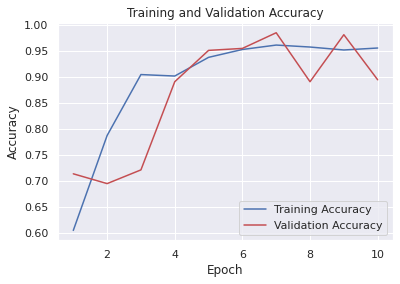

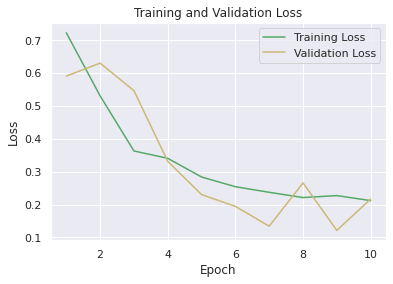

In [21]:
History_metrics(history)

              precision    recall  f1-score   support

           0       1.00      0.44      0.61       261
           1       0.77      1.00      0.87       499

    accuracy                           0.81       760
   macro avg       0.89      0.72      0.74       760
weighted avg       0.85      0.81      0.78       760



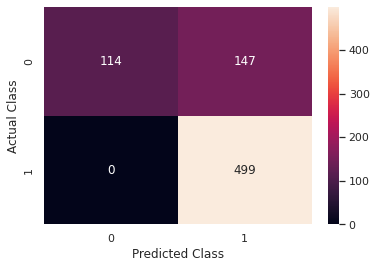

In [22]:
mag_acc[0] = Model_report(y_test, y_pred)

In [ ]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model100.save("models/trained_bin_100_1")

# Magnification: 200x

In [23]:
mag = 200

## Fold 1

In [24]:
m, history, y_test, y_pred = Train(mag, 1)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
63/63 [==============================] - 40s 343ms/step - loss: 0.7011 - accuracy: 0.6158 - val_loss: 0.5546 - val_accuracy: 0.7480
Epoch 2/10
63/63 [==============================] - 16s 250ms/step - loss: 0.5019 - accuracy: 0.7921 - val_loss: 0.4592 - val_accuracy: 0.7835
Epoch 3/10
63/63 [==============================] - 16s 256ms/step - loss: 0.3764 - accuracy: 0.8808 - val_loss: 0.3788 - val_accuracy: 0.8228
Epoch 4/10
63/63 [==============================] - 16s 249ms/step - loss: 0.3565 - accuracy: 0.8847 - val_loss: 0.2286 - val_accuracy: 0.9370
Epoch 5/10
63/63 [==============================] - 16s 256ms/step - loss: 0.2609 - accuracy: 0.9360 - val_loss: 0.3357 - val_accuracy: 0.8346
Epoch 6/10
63/63 [============================

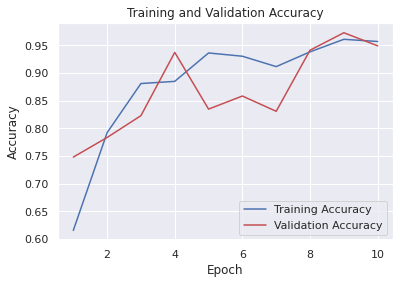

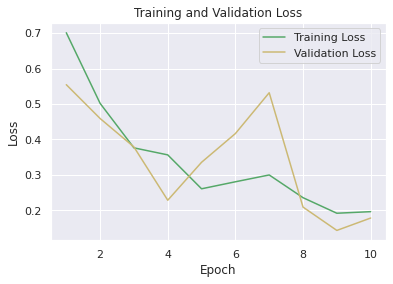

In [25]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.78      0.67      0.72       255
           1       0.84      0.90      0.87       489

    accuracy                           0.82       744
   macro avg       0.81      0.79      0.80       744
weighted avg       0.82      0.82      0.82       744



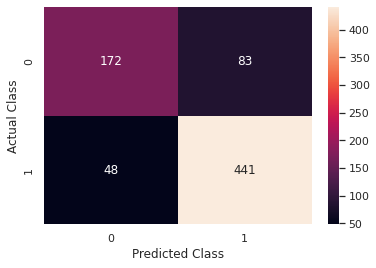

In [26]:
mag_acc[1] = Model_report(y_test, y_pred)

In [27]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model200.save("models/trained_bin_200_1")

# Magnification: 40x

In [28]:
mag = 40

## Fold 1

In [29]:
m, history, y_test, y_pred = Train(mag, 1)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
62/62 [==============================] - 39s 321ms/step - loss: 0.7213 - accuracy: 0.6050 - val_loss: 0.5213 - val_accuracy: 0.7320
Epoch 2/10
62/62 [==============================] - 16s 260ms/step - loss: 0.5588 - accuracy: 0.7190 - val_loss: 0.4905 - val_accuracy: 0.7520
Epoch 3/10
62/62 [==============================] - 16s 248ms/step - loss: 0.3963 - accuracy: 0.8470 - val_loss: 0.3422 - val_accuracy: 0.8520
Epoch 4/10
62/62 [==============================] - 16s 261ms/step - loss: 0.3390 - accuracy: 0.8900 - val_loss: 0.2444 - val_accuracy: 0.9280
Epoch 5/10
62/62 [==============================] - 15s 246ms/step - loss: 0.2879 - accuracy: 0.9300 - val_loss: 0.2784 - val_accuracy: 0.8960
Epoch 6/10
62/62 [============================

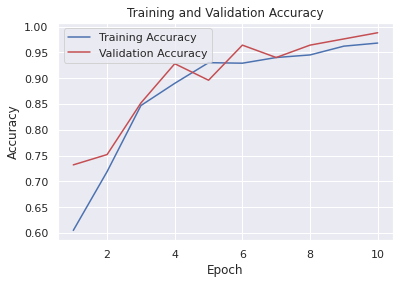

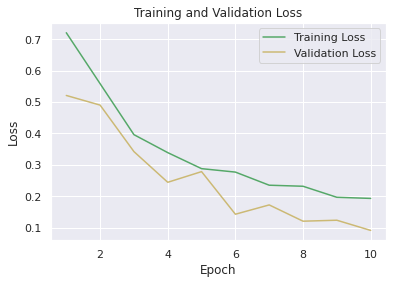

In [30]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       255
           1       0.92      0.97      0.94       490

    accuracy                           0.92       745
   macro avg       0.92      0.90      0.91       745
weighted avg       0.92      0.92      0.92       745



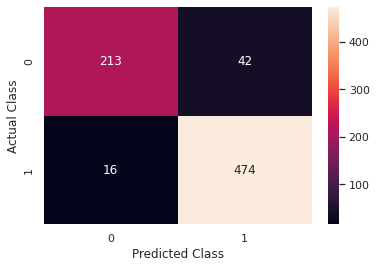

In [31]:
mag_acc[2] = Model_report(y_test, y_pred)

In [32]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model40.save("models/trained_bin_40_1")

# Magnification: 400x

In [33]:
mag = 400

## Fold 1

In [34]:
m, history, y_test, y_pred = Train(mag, 1)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
58/58 [==============================] - 38s 350ms/step - loss: 0.7646 - accuracy: 0.5687 - val_loss: 0.6175 - val_accuracy: 0.6867
Epoch 2/10
58/58 [==============================] - 15s 254ms/step - loss: 0.5623 - accuracy: 0.7425 - val_loss: 0.5728 - val_accuracy: 0.6738
Epoch 3/10
58/58 [==============================] - 15s 253ms/step - loss: 0.4101 - accuracy: 0.8616 - val_loss: 0.6006 - val_accuracy: 0.6996
Epoch 4/10
58/58 [==============================] - 15s 259ms/step - loss: 0.3369 - accuracy: 0.8863 - val_loss: 0.4864 - val_accuracy: 0.7253
Epoch 5/10
58/58 [==============================] - 15s 255ms/step - loss: 0.3022 - accuracy: 0.9152 - val_loss: 0.2443 - val_accuracy: 0.9099
Epoch 6/10
58/58 [============================

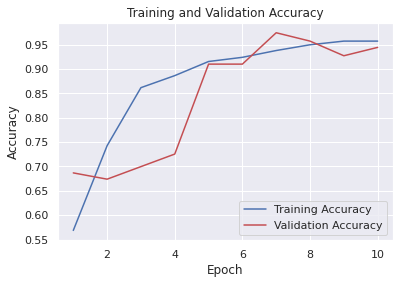

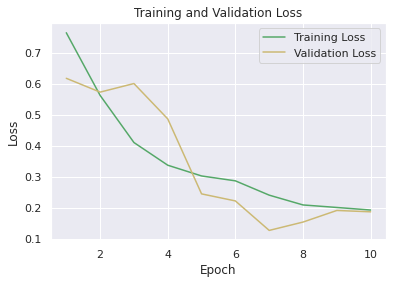

In [35]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       237
           1       0.90      0.80      0.85       418

    accuracy                           0.82       655
   macro avg       0.80      0.82      0.81       655
weighted avg       0.83      0.82      0.82       655



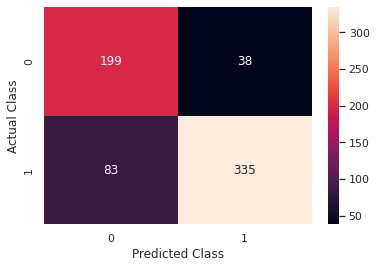

In [36]:
mag_acc[3] = Model_report(y_test, y_pred)

In [ ]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model400.save("models/trained_bin_400_1")